## Setting Up

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from numpy.fft import fft, fftfreq

In [2]:
def set_seed(seed=42):

    np.random.seed(seed)

set_seed(42)

## Format Data

In [ ]:
data_path = r"../data/UK_data"
file_paths = ['CPI.csv', 'PPI.csv', '3mth Interest Rate.csv', 'Composite Consumer Confidence.csv',
              'gbp_usd_daily.csv', 'Gross GDP Mkt prices.csv', 'Unemployment rates (15 year old plus).csv'] # , 'Gross GDP Index.csv'


In [4]:
SEASONAL_PERIOD = 12

## Load Data

In [5]:
def load_data(file_paths):
    """
    Load multiple CSV files into a single DataFrame by merging them on the 'Date' column.
    
    Parameters:
        file_paths (list): List of strings representing CSV file paths.
    
    Returns:
        df (DataFrame): Merged DataFrame containing data from all files.
    """
    dfs = []
    for file in file_paths:
        print(f"loading {file}")
        if file == 'Composite Consumer Confidence.csv' or file == 'Unemployment rates (15 year old plus).csv':
            file_ = os.path.join(data_path, file)
            temp_df = pd.read_csv(file_)
            columns_to_keep = ['TIME_PERIOD','OBS_VALUE']
            temp_df = temp_df[columns_to_keep]
            temp_df = temp_df.rename(columns={'TIME_PERIOD': 'Date', 'OBS_VALUE': f'{file}'})
            temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y-%m')
            dfs.append(temp_df)
            print(f"Loaded {file} with shape: {temp_df.shape}")
        elif file == 'Gross GDP Index.csv':
            file = os.path.join(data_path, file)
            headers = pd.read_csv(file, nrows=1).columns
            temp_df = pd.read_csv(file, skiprows=7, usecols=range(24), names = headers, header = None)
            temp_df = temp_df.rename(columns={'Title': 'Date'})
            temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y %b')
            dfs.append(temp_df)
            print(f"Loaded {file} with shape: {temp_df.shape}")
        elif file == 'Gross GDP Mkt prices.csv':
            file = os.path.join(data_path, file)
            headers = pd.read_csv(file, nrows=1).columns
            temp_df = pd.read_csv(file, skiprows=85, names = headers, header = None)
            temp_df = temp_df.rename(columns={'Title': 'Date'})
            temp_df['Date'] = temp_df['Date'].str.replace(" ", "-", regex=False)
            temp_df['Date'] = pd.to_datetime(temp_df['Date'])
            dfs.append(temp_df)
            print(f"Loaded {file} with shape: {temp_df.shape}")
        elif file == 'gbp_usd_daily.csv':
            file_ = os.path.join(data_path, file)
            temp_df = pd.read_csv(file_)
            temp_df = temp_df.rename(columns={'DATE': 'Date', 'DEXUSUK': 'gbp_usd'}) 
            temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y-%m-%d')
            dfs.append(temp_df)
            print(f"Loaded {file} with shape: {temp_df.shape}")
        else:
            file_ = os.path.join(data_path, file)
            temp_df = pd.read_csv(file_)
            temp_df = temp_df.rename(columns={'observation_date': 'Date', temp_df.columns[1]: f'{file}'})
            temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y-%m-%d')
            dfs.append(temp_df)
            print(f"Loaded {file} with shape: {temp_df.shape}")
    
    # Merge datasets on 'Date' column using an outer join to retain all records.
    df = dfs[0]
    for temp_df in dfs[1:]:
        df = pd.merge(df, temp_df, on='Date', how='outer')
    
    # Display basic dataset information
    print("Combined DataFrame shape:", df.shape)
    print("DataFrame columns:", df.columns.tolist())
    print(df.head())
    
    return df

In [6]:
df = load_data(file_paths)

loading CPI.csv
Loaded CPI.csv with shape: (840, 2)
loading PPI.csv
Loaded PPI.csv with shape: (756, 2)
loading 3mth Interest Rate.csv
Loaded 3mth Interest Rate.csv with shape: (469, 2)
loading Composite Consumer Confidence.csv
Loaded Composite Consumer Confidence.csv with shape: (807, 2)
loading gbp_usd_daily.csv
Loaded gbp_usd_daily.csv with shape: (14088, 2)
loading Gross GDP Mkt prices.csv
Loaded ../data\Gross GDP Mkt prices.csv with shape: (280, 2)
loading Unemployment rates (15 year old plus).csv
Loaded Unemployment rates (15 year old plus).csv with shape: (503, 2)
Combined DataFrame shape: (14466, 8)
DataFrame columns: ['Date', 'CPI.csv', 'PPI.csv', '3mth Interest Rate.csv', 'Composite Consumer Confidence.csv', 'gbp_usd', 'Gross Domestic Product at market prices: Current price: Seasonally adjusted £m', 'Unemployment rates (15 year old plus).csv']
        Date   CPI.csv  PPI.csv  3mth Interest Rate.csv  \
0 1955-01-01  4.859513      NaN                     NaN   
1 1955-02-01  4.

C:\Users\Justin\AppData\Local\Temp\ipykernel_20516\2895755022.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_df['Date'] = pd.to_datetime(temp_df['Date'])


In [7]:
df

,Date,CPI.csv,PPI.csv,3mth Interest Rate.csv,Composite Consumer Confidence.csv,gbp_usd,Gross Domestic Product at market prices: Current price: Seasonally adjusted £m,Unemployment rates (15 year old plus).csv
0,1955-01-01,4.859513,NaN,NaN,NaN,NaN,4666.0,NaN
1,1955-02-01,4.859513,NaN,NaN,NaN,NaN,NaN,NaN
2,1955-03-01,4.859513,NaN,NaN,NaN,NaN,NaN,NaN
3,1955-04-01,4.885972,NaN,NaN,NaN,NaN,4688.0,NaN
4,1955-05-01,4.877152,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14461,2024-12-27,NaN,NaN,NaN,NaN,1.2573,NaN,NaN
14462,2024-12-30,NaN,NaN,NaN,NaN,1.2523,NaN,NaN
14463,2024-12-31,NaN,NaN,NaN,NaN,1.2521,NaN,NaN
14464,2025-01-01,NaN,NaN,4.55,101.0870,NaN,NaN,NaN


## Preprocess Data

In [ ]:
def preprocess_data(df):
    """
    Clean and preprocess the DataFrame:
      - Rename column names properly
      - Convert 'Date' column to datetime and set as index.
      - Remove duplicate records.
      - Interpolate missing values.
      - Identify outliers in CPI using the Z-score method.
      - Check stationarity of the CPI series using the ADF test and plot the PACF.
        Apply first-order differencing if the series is non-stationary.
      - Identify if seasonal adjustment is needed and perform seasonal decomposition.
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        df (DataFrame): Preprocessed DataFrame with new columns added.
    """
    df.rename(columns=lambda col: col[:-4] if col.endswith('.csv') else col, inplace=True)

    # Convert 'Date' to datetime and sort the DataFrame by date
    assert pd.api.types.is_datetime64_any_dtype(df['Date']), "Date column is not in datetime format"
    df.sort_values('Date', inplace=True)

    # Remove duplicate records
    df.drop_duplicates(inplace=True)
    df = df[df['Date'] >= '1986-01-01']
    df = df[df['Date'].dt.day == 1]

    # Set 'Date' as the index for time series operations
    df.set_index('Date', inplace=True)

    # Handle missing values using time-based interpolation
    df.interpolate(method='time', inplace=True)
    df['gbp_usd'] = df['gbp_usd'].ffill().bfill() # Leading missing values which does not seem to vary much

    # Identify outliers in the CPI column using Z-score (flag values with absolute z-score > 3)
    df['CPI_zscore'] = zscore(df['CPI'])
    df['CPI_outlier'] = df['CPI_zscore'].abs() > 3
    outliers = df[df['CPI_outlier']]  # Filter rows where CPI_outlier is True
    if outliers.empty:
        print("No outliers for CPI based on Z-Score")
    else:
        print("Outlier for CPI based on Z-Score: ", outliers)

    # Plot Partial Autocorrelation Function (PACF) for CPI
    plt.figure(figsize=(10, 4))
    plot_pacf(df['CPI'].dropna(), lags=20, method='ywm')
    plt.title('PACF for CPI')
    plt.show()

    # List of macroeconomic indicators to check
    macro_indicators_stationarity_check = [col for i, col in enumerate(df.columns) if i in [0,1,2,4,6]]

    for indicator in macro_indicators_stationarity_check:
        if indicator in df.columns:  # Check if the column exists in DataFrame
            series = df[indicator].dropna()

            # Perform Augmented Dickey-Fuller test
            adf_result = adfuller(series)
            p_value = adf_result[1]

            print(f"\nADF Statistic for {indicator}: {adf_result[0]}")
            print(f"p-value for {indicator}: {p_value}")

            # Apply first-order differencing if non-stationary
            if p_value > 0.05:
                df[f'{indicator}_diff'] = df[indicator].diff().dropna()
                print(f"{indicator} series is non-stationary (p-value > 0.05), so first-order differencing was applied.")
            else:
                print(f"{indicator} series is stationary. No differencing applied.")
    
    # If CPI is non-stationary (p-value > 0.05), apply first-order differencing
    if adf_result[1] > 0.05:
        df['CPI_diff'] = df['CPI'].diff().dropna()
        print("CPI series is non-stationary since p-value > 0.05, Fail to reject H₀. Applied first-order differencing.")
    else:
        print("CPI series is stationary. No differencing applied.")
    
    # Seasonal adjustment using seasonal decomposition.
    # Use the differenced series if available; otherwise, use the original CPI series.
    macro_indicators_seasonal_adj = [col for i, col in enumerate(df.columns) if i in [0, 1, 2, 4, 6]]
    for indicator in macro_indicators_seasonal_adj:
        if indicator in df.columns:
            series_to_decompose = df[indicator].dropna()
            try:
                # Perform seasonal decomposition
                decomposition = seasonal_decompose(series_to_decompose, model='additive', period=SEASONAL_PERIOD)
                
                # Store the decomposition components
                df[f'{indicator}_trend'] = decomposition.trend
                df[f'{indicator}_seasonal'] = decomposition.seasonal
                df[f'{indicator}_resid'] = decomposition.resid
                
                # Create seasonally adjusted series (Observed - Seasonal Component)
                df[f'{indicator}_SA'] = df[indicator] - decomposition.seasonal
                
                # Plot the seasonal decomposition components
                decomposition.plot()
                plt.suptitle(f'Seasonal Decomposition of {indicator}')
                plt.show()

            except Exception as e:
                print(f"Seasonal decomposition failed for {indicator}:", e)
        else:
            print(f"{indicator} does not exist in DataFrame")

    try:
        decomposition = seasonal_decompose(series_to_decompose.dropna(), model='additive', period=SEASONAL_PERIOD)
        df['trend'] = decomposition.trend
        df['seasonal'] = decomposition.seasonal
        df['resid'] = decomposition.resid
        
        # Plot the seasonal decomposition components
        decomposition.plot()
        plt.suptitle('Seasonal Decomposition of CPI')
        plt.show()
    except Exception as e:
        print("Seasonal decomposition failed:", e)
    
    return df

No outliers for CPI based on Z-Score


<Figure size 1000x400 with 0 Axes>

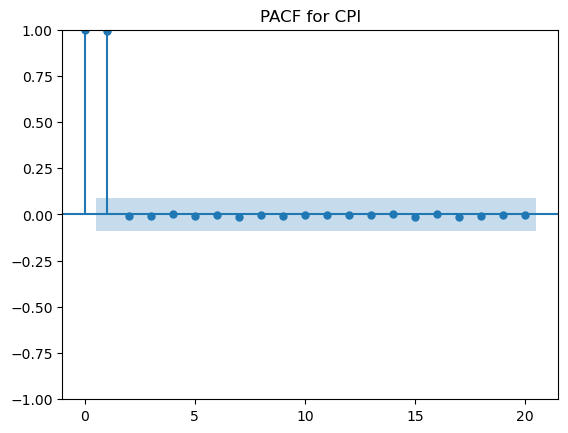


ADF Statistic for CPI: 1.333319052579418
p-value for CPI: 0.9967891287732106
CPI series is non-stationary (p-value > 0.05), so first-order differencing was applied.

ADF Statistic for PPI: 0.28936246549115097
p-value for PPI: 0.9768511443637509
PPI series is non-stationary (p-value > 0.05), so first-order differencing was applied.

ADF Statistic for 3mth Interest Rate: -1.4181139512140595
p-value for 3mth Interest Rate: 0.5735619175848722
3mth Interest Rate series is non-stationary (p-value > 0.05), so first-order differencing was applied.

ADF Statistic for gbp_usd: -2.5468274160017863
p-value for gbp_usd: 0.10449231940429327
gbp_usd series is non-stationary (p-value > 0.05), so first-order differencing was applied.

ADF Statistic for Unemployment rates (15 year old plus): -2.7308085863721425
p-value for Unemployment rates (15 year old plus): 0.06885707470783482
Unemployment rates (15 year old plus) series is non-stationary (p-value > 0.05), so first-order differencing was applied.
C

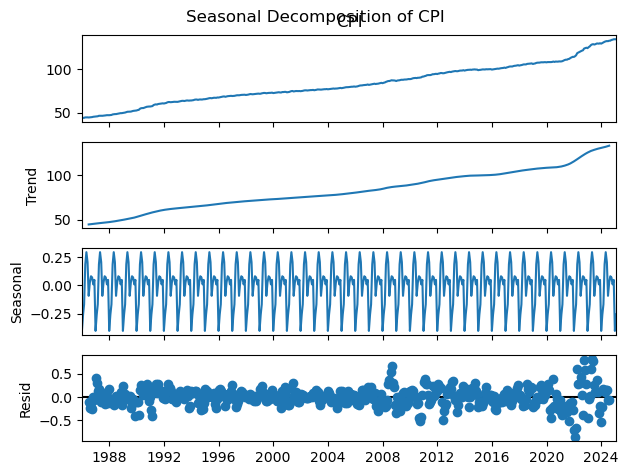

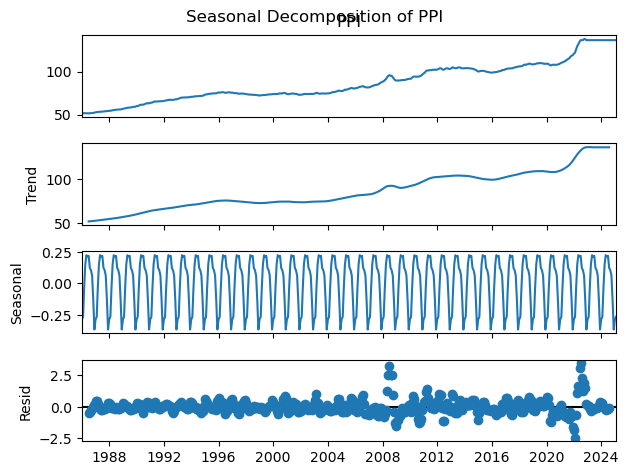

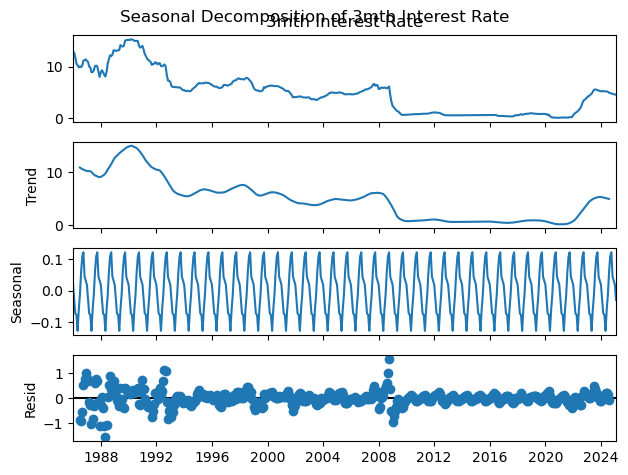

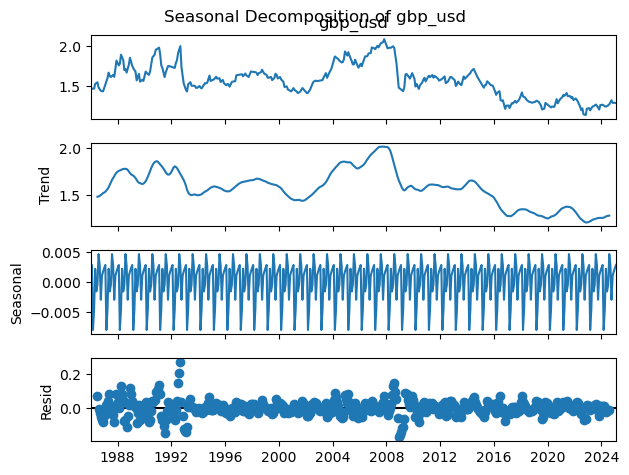

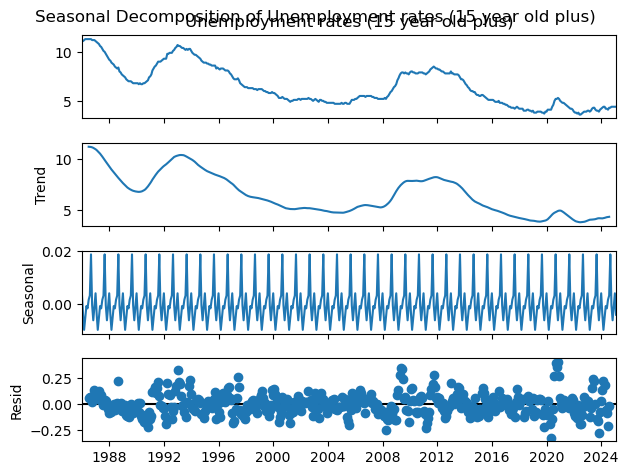

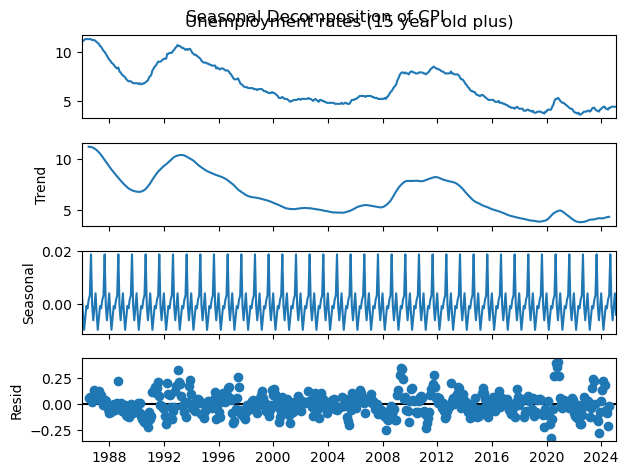

In [9]:
df = preprocess_data(df)

- pacf plot shows that 1st differencing is needed
- seasonal decomposition plots show that seasonal components exist in all the series that I examined
- seasonal decomposition plots show that generally residuals (component unexplained by either long term trend or seasonality) peaks for all plots somewhere around 1992, 2008 and 2020
- these probably correspond so some financial crisis or some event

In [10]:
df

,CPI,PPI,3mth Interest Rate,Composite Consumer Confidence,gbp_usd,Gross Domestic Product at market prices: Current price: Seasonally adjusted £m,Unemployment rates (15 year old plus),CPI_zscore,CPI_outlier,CPI_diff,...,gbp_usd_seasonal,gbp_usd_resid,gbp_usd_SA,Unemployment rates (15 year old plus)_trend,Unemployment rates (15 year old plus)_seasonal,Unemployment rates (15 year old plus)_resid,Unemployment rates (15 year old plus)_SA,trend,seasonal,resid
Date,,,,,,,,,,,,,,,,,,,,,
1986-01-01,43.67648,51.456058,12.86300,99.71179,1.4710,108753.000000,11.2,-1.761126,False,NaN,...,0.002305,NaN,1.468695,NaN,0.004176,NaN,11.195824,NaN,0.004176,NaN
1986-02-01,43.85808,51.456058,12.71875,99.70575,1.4710,109209.733333,11.1,-1.753043,False,0.18160,...,0.002812,NaN,1.468188,NaN,-0.003938,NaN,11.103938,NaN,-0.003938,NaN
1986-03-01,43.90348,51.456058,11.77679,99.74067,1.4710,109622.266667,11.2,-1.751022,False,0.04540,...,-0.007912,NaN,1.478912,NaN,-0.009640,NaN,11.209640,NaN,-0.009640,NaN
1986-04-01,44.35750,51.612699,10.57670,99.80801,1.4710,110079.000000,11.3,-1.730815,False,0.45402,...,-0.004482,NaN,1.475482,NaN,-0.005035,NaN,11.305035,NaN,-0.005035,NaN
1986-05-01,44.40290,51.377741,10.26705,99.85727,1.5292,110708.670330,11.3,-1.728794,False,0.04540,...,0.002181,NaN,1.527019,NaN,-0.000649,NaN,11.300649,NaN,-0.000649,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,134.30000,136.488626,4.75000,101.33200,1.3282,724724.000000,4.4,2.272366,False,0.80000,...,-0.002923,NaN,1.331123,NaN,-0.000320,NaN,4.400320,NaN,-0.000320,NaN
2024-11-01,134.60000,136.488626,4.68000,101.21320,1.2959,724724.000000,4.4,2.285719,False,0.30000,...,0.001051,NaN,1.294849,NaN,-0.006022,NaN,4.406022,NaN,-0.006022,NaN
2024-12-01,135.10000,136.488626,4.64000,101.12320,1.2959,724724.000000,4.4,2.307973,False,0.50000,...,0.001717,NaN,1.294183,NaN,-0.000978,NaN,4.400978,NaN,-0.000978,NaN


## EDA

In [11]:
def exploratory_data_analysis(df):
    """
    Perform Exploratory Data Analysis (EDA):
      - Plot the time series trend for CPI inflation.
      - Create a correlation heatmap for key macroeconomic variables.
      - Plot a scatter plot for the Phillips Curve (CPI vs. Unemployment Rate).
      - Generate a boxplot for CPI to identify outliers.
      - Compare inflation trends across two countries (if data available).
      - Apply Fast Fourier Transform (FFT) to detect cyclical patterns.
      - Use Continuous Wavelet Transform (CWT) with PyWavelets to detect localized shocks and business cycles.
    
    Parameters:
        df (DataFrame): DataFrame with processed and engineered features.
    """
    # Reset index to have 'Date' as a column for plotting
    df_plot = df.reset_index()

    indicators = ['CPI', 'PPI', '3mth Interest Rate', 'Composite Consumer Confidence',
    'gbp_usd',
    'Gross Domestic Product at market prices: Current price: Seasonally adjusted £m',
    'Unemployment rates (15 year old plus)']
    
    # 1. Plot time series
    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())
    
    plt.figure(figsize=(12, 6))
    for indicator in indicators:
        if indicator in df_plot.columns:
            print(indicator)
            normalized_series = min_max_scaling(df_plot[indicator])
            if indicator == 'CPI':
                plt.plot(df_plot['Date'], normalized_series, label=indicator)

            else: 
                plt.plot(df_plot['Date'], normalized_series, label=indicator)
    plt.title('CPI Inflation Rate Over Time')
    plt.xlabel('Date')
    plt.ylabel('CPI')
    plt.legend()
    plt.show()
    
    # 2. Correlation heatmap for selected macroeconomic variables

    # Ensure these columns exist in the DataFrame
    columns_for_corr = [col for col in indicators if col in df.columns]
    if columns_for_corr:
        plt.figure(figsize=(10, 8))
        corr_matrix = df[columns_for_corr].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix of Macroeconomic Variables')
        plt.show()
    
    # 3. Scatter plot for Phillips Curve: CPI vs. Unemployment Rate (if available)
    if 'Unemployment rate' in df.columns:
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Unemployment rate'], df['CPI'])
        plt.title('Phillips Curve: CPI vs. Unemployment Rate')
        plt.xlabel('Unemployment Rate')
        plt.ylabel('CPI Inflation Rate')
        plt.show()
    
    # 8. Highlight periods of crisis by detecting extreme changes in CPI.
    # Define crisis as periods where the percentage change in CPI exceeds the 95th percentile.
    crisis_threshold = df_plot['CPI_diff'].quantile(0.95)
    crisis_periods = df_plot[df_plot['CPI_diff'] > crisis_threshold]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot['Date'], df_plot['CPI'], label='CPI')
    for _, row in crisis_periods.iterrows():
        plt.axvspan(row['Date'], row['Date'], color='red', alpha=0.3)
    plt.title('CPI Inflation - Highlighted Potential Crisis Periods')
    plt.xlabel('Date')
    plt.ylabel('CPI')
    plt.legend()
    plt.show()


CPI
PPI
3mth Interest Rate
Composite Consumer Confidence
gbp_usd
Gross Domestic Product at market prices: Current price: Seasonally adjusted £m
Unemployment rates (15 year old plus)


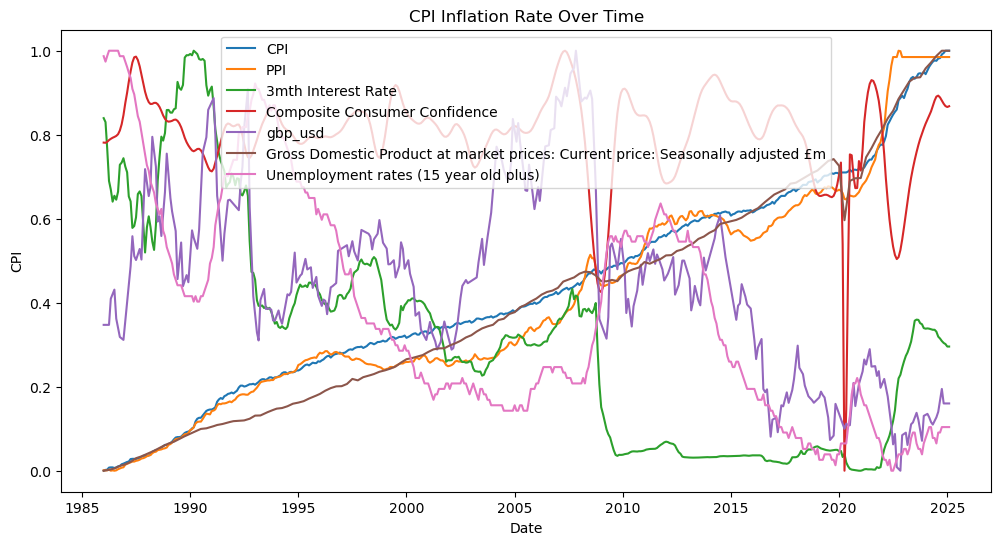

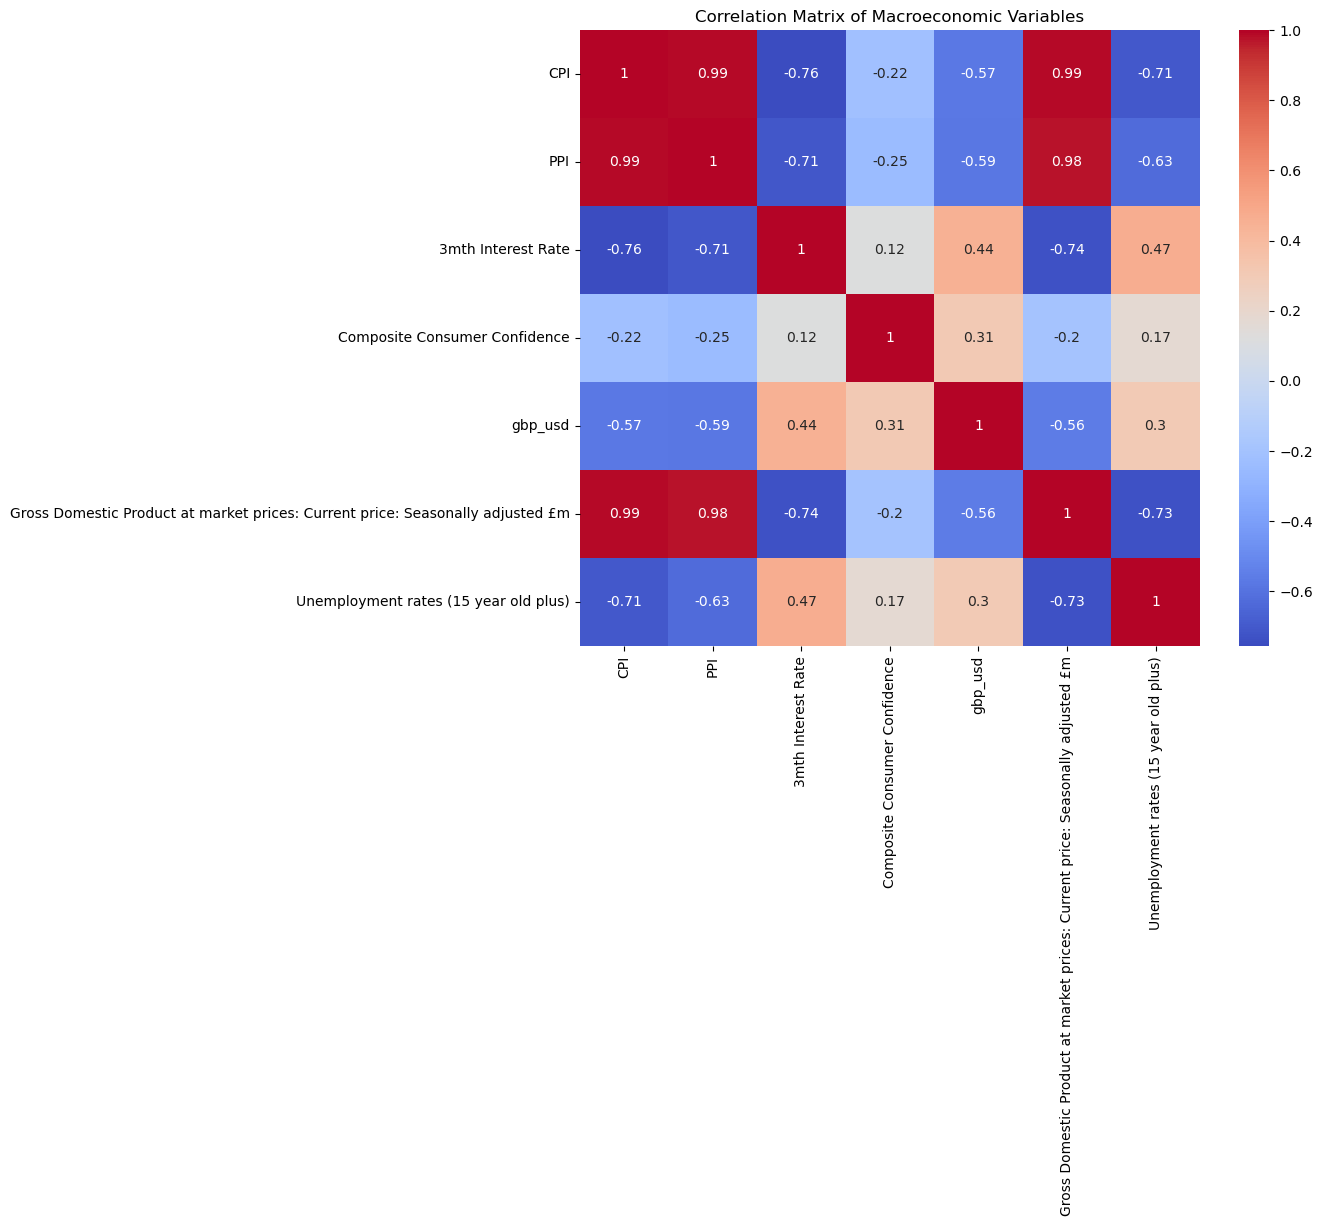

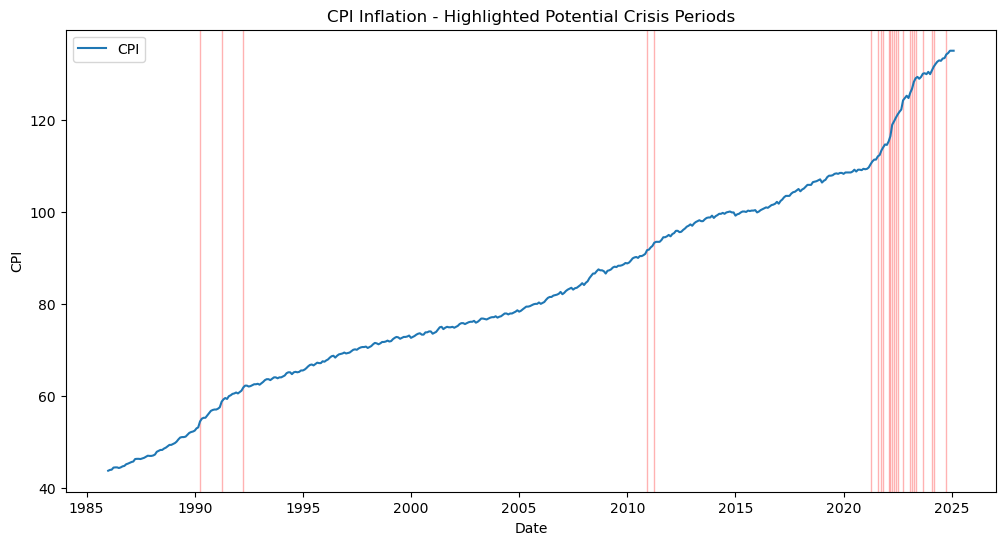

In [12]:
exploratory_data_analysis(df)

From time series plot
- CCI, PPI and GDP moves together (expected, from econs theory)
- exchange rate and interest rate move together (expected from theory)
- consumer confidence tanks at 2008 and 2020, corresponding to great recession
- unemployment rise in 1990 and 2008

From Corr matrix
- same thang

From CPI outlier plot
- 1990 correspond to recession + unemployment rise same time
- 2011 correspond to the financial crisis and unemployment rise. UK Gov said is energy prices + food cost
- 2021 - 2024 bruh.

In [ ]:
# df.to_csv('../data/UK_consolidated_df.csv'))